# Burgers Equation with Boundary Conditions

In [1]:
import os
import sys
sys.path.append("../")

import math
from scipy import special
import numpy as np
import torch
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import logging
from pynverse import inversefunc
from utilities.compare_performance import compare_performance
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from functools import partial

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## PINN Continuous Method

In [2]:
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)
viscosity = 0.01/pi

# Define initial condition
def fun_u_0(x):
    return -tf.sin(pi*x)

# Define boundary condition
def fun_u_b(t, x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

# Define residual of the PDE
def fun_r(t, x, u, u_t, u_x, u_xx):
    return u_t + u * u_x - viscosity * u_xx

In [3]:
# Set number of data points
N_0 = 50
N_b = 50
N_r = 10000

# Set boundary
tmin = 0.
tmax = 0.1
xmin = -1.
xmax = 1.

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0], axis=1)

# Evaluate intitial condition at x_0
u_0 = fun_u_0(x_0)

# Boundary data
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b = tf.concat([t_b, x_b], axis=1)

# Evaluate boundary condition at (t_b,x_b)
u_b = fun_u_b(t_b, x_b)

# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

# Collect boundary and inital data in lists
X_data = [X_0, X_b]
u_data = [u_0, u_b]

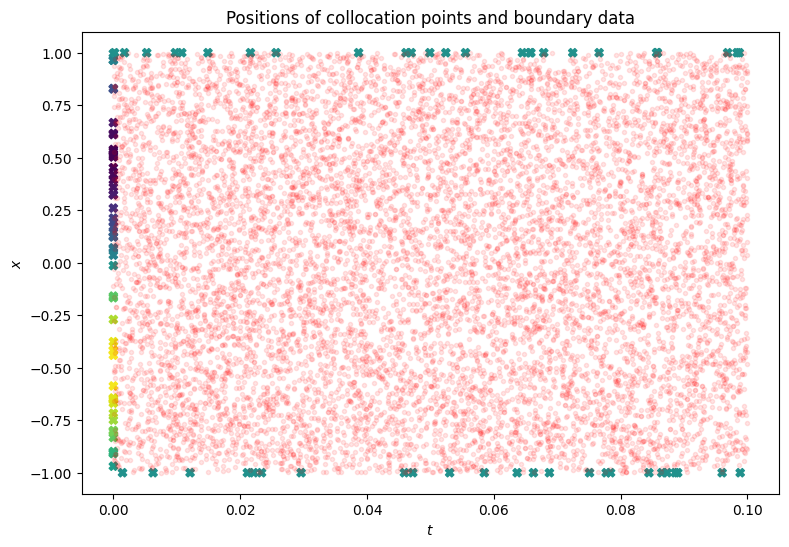

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
plt.scatter(t_0, x_0, c=u_0, marker='X', vmin=-1, vmax=1)
plt.scatter(t_b, x_b, c=u_b, marker='X', vmin=-1, vmax=1)
plt.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data');

In [5]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))
    
    return model

In [6]:
def get_r(model, X_r):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x = X_r[:, 0:1], X_r[:,1:2]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(t)
        tape.watch(x)

        # Determine residual 
        u = model(tf.stack([t[:,0], x[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_x = tape.gradient(u, x)
            
    u_t = tape.gradient(u, t)
    u_xx = tape.gradient(u_x, x)

    del tape

    return fun_r(t, x, u, u_t, u_x, u_xx)

In [7]:
def compute_loss(model, X_r, X_data, u_data):
    
    # Compute phi^r
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))
    
    # Initialize loss
    loss = phi_r
    
    # Add phi^0 and phi^b to the loss
    for i in range(len(X_data)):
        u_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))
    
    return loss

In [8]:
def get_grad(model, X_r, X_data, u_data):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [9]:
# Initialize model aka u_\theta
model = init_model()

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [10]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_data, u_data)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    
    return loss

# Number of training epochs
N = 5000
hist = []

# Start timer
t0 = time()

for i in range(N+1):
    
    loss = train_step()
    
    # Append current loss to hist
    hist.append(loss.numpy())
    
    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 1.08206663e+01
It 00050: loss = 3.83653224e-01
It 00100: loss = 3.39550227e-01
It 00150: loss = 3.19811642e-01
It 00200: loss = 2.98707545e-01
It 00250: loss = 2.72582263e-01
It 00300: loss = 2.30347767e-01
It 00350: loss = 1.53825730e-01
It 00400: loss = 6.49409369e-02
It 00450: loss = 3.72096360e-01
It 00500: loss = 1.09026447e-01
It 00550: loss = 3.95799875e-02
It 00600: loss = 1.54119339e-02
It 00650: loss = 7.67350709e-03
It 00700: loss = 4.93154814e-03
It 00750: loss = 3.63286398e-03
It 00800: loss = 2.86209048e-03
It 00850: loss = 2.32580095e-03
It 00900: loss = 1.91741588e-03
It 00950: loss = 1.06722256e-02
It 01000: loss = 1.96907925e-03
It 01050: loss = 1.49999955e-03
It 01100: loss = 1.45422306e-03
It 01150: loss = 1.41646608e-03
It 01200: loss = 1.38198712e-03
It 01250: loss = 1.34946569e-03
It 01300: loss = 1.31831178e-03
It 01350: loss = 1.28818548e-03
It 01400: loss = 1.25888351e-03
It 01450: loss = 1.23026595e-03
It 01500: loss = 1.20224420e-03
It 01550

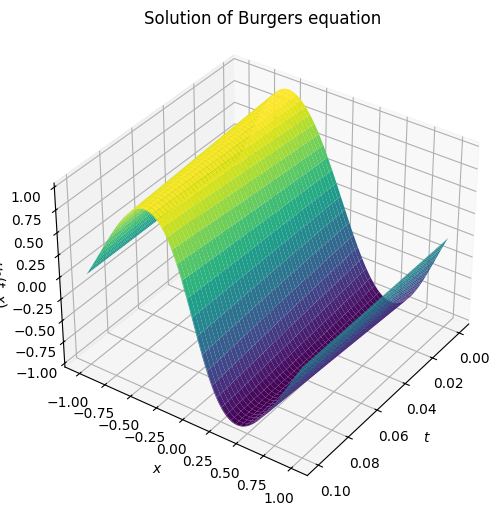

In [11]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 600
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Determine predictions of u(t, x)
upred = model(tf.cast(Xgrid,DTYPE))

# Reshape upred
U = upred.numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='viridis');
ax.view_init(35,35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u_\\theta(t,x)$')
ax.set_title('Solution of Burgers equation');

## DB, BSDE, DGM

In [12]:
# function definition
deriv_map = np.array([0, 1]).reshape(-1, 1)
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    """
    return -y[0]*y[1]

dgm_deriv_map = np.array([0,1,2]).reshape(-1, 1)
def dgm_f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    return -y[0]*y[1] + (0.01/torch.pi)*y[2]

def phi_example(x, coordinate=0):
    return -torch.sin(torch.pi*x[0])

def boundary_fun(x, coordinate=0):
    return torch.tensor(np.zeros(x.size()[1]), device=device).to(torch.float32)

t_low, x_low, x_high = 0., -1., 1.
grid = np.linspace(x_low, x_high, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_low * np.ones((1, 100)), grid_d_dim), axis=0)

T = 0.1
terminal = -np.sin(np.pi*grid_d_dim)[0]

termi_data = tf.convert_to_tensor(np.dstack([grid_d_dim_with_t[0]+0.1, grid_d_dim_with_t[1]])[0])
true = model(termi_data).numpy()[:,0]

In [13]:
# Conditional probability to survive
# Set boundary of DB and BSDE methods
def conditional_probability_to_survive(
    t,
    x,
    y,
    k_arr=range(-5, 5),
    lower_bound=-1,
    upper_bound=1,
):
    # in case lower_bound & upper_bound are not tensor
    if not torch.is_tensor(lower_bound):
        lower_bound = torch.tensor(lower_bound, device=device)
    if not torch.is_tensor(upper_bound):
        upper_bound = torch.tensor(upper_bound, device=device)

    # transpose (t, x, y)
    # so that the operation with lower_bound, upper_bound is correct
    t = t.unsqueeze(dim=0).transpose(0, -1)
    x, y = x.transpose(0, -1), y.transpose(0, -1)

    # calculate the probability using the formula by Borodin
    ans = 0
    for k in k_arr:
        ans += (
            torch.exp(
                ((y - x) ** 2 - (y - x + 2*k*(upper_bound-lower_bound)) ** 2) 
                / (2 * t)
            )
            - torch.exp(
                ((y - x) ** 2 - (y + x - 2*lower_bound + 2*k*(upper_bound-lower_bound)) ** 2) 
                / (2 * t)
            )
        )
    # print(ans.transpose(0, -1).prod(dim=0))
    return ans.transpose(0, -1).prod(dim=0)

def is_x_inside(x, lower_bound=-1, upper_bound=1):
    # in case lower_bound & upper_bound are not tensor
    if not torch.is_tensor(lower_bound):
        lower_bound = torch.tensor(lower_bound, device=device)
    if not torch.is_tensor(upper_bound):
        upper_bound = torch.tensor(upper_bound, device=device)

    # transpose x so that the operation with lower_bound, upper_bound is correct
    x = x.transpose(0, -1)

    return (
        torch.logical_and(lower_bound <= x, x <= upper_bound)
        .transpose(0, -1).all(dim=0)
    )

Logs are saved in C:\Users\User\OneDrive - Nanyang Technological University\School\Modules\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


#### Starting deep branching method with seed 0 - 1 out of 1 times
Generating batch 1/5
Generating batch 2/5
Generating batch 3/5
Generating batch 4/5
Generating batch 5/5


Patch 0: generation of u samples take 1605.57524228096 seconds.
Patch  0: epoch    0 with loss 2.41E+00


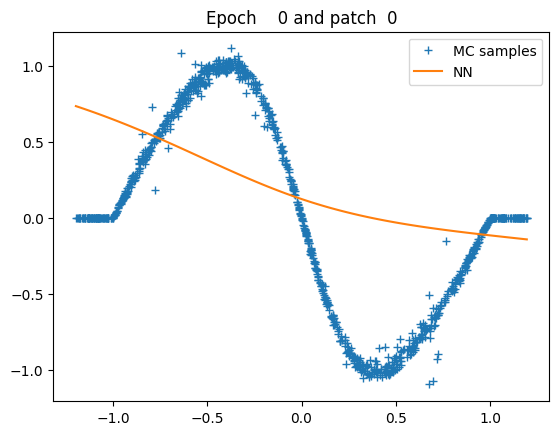

Patch  0: epoch  500 with loss 1.87E-03


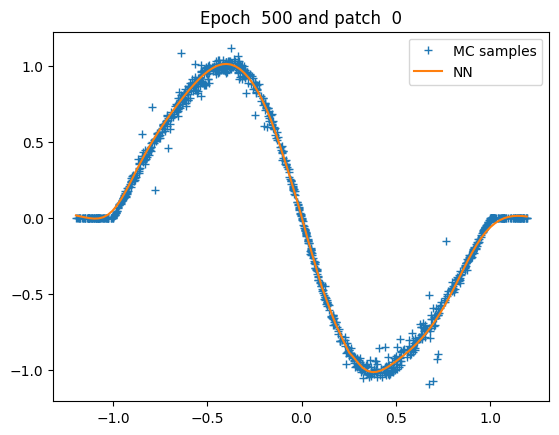

Patch  0: epoch 1000 with loss 1.80E-03


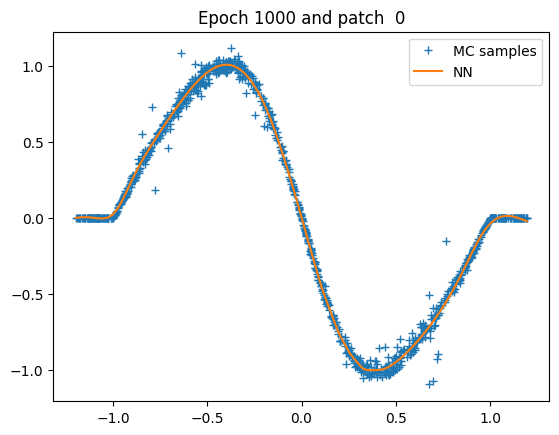

Patch  0: epoch 1500 with loss 1.80E-03


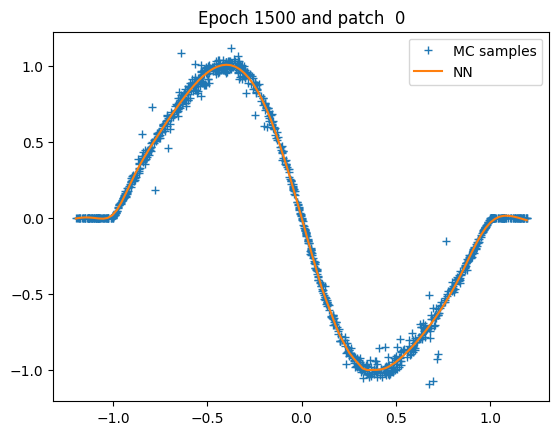

Patch  0: epoch 2000 with loss 1.79E-03


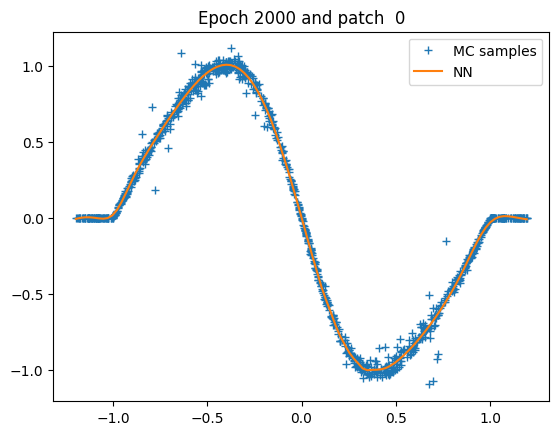

Patch  0: epoch 2500 with loss 1.79E-03


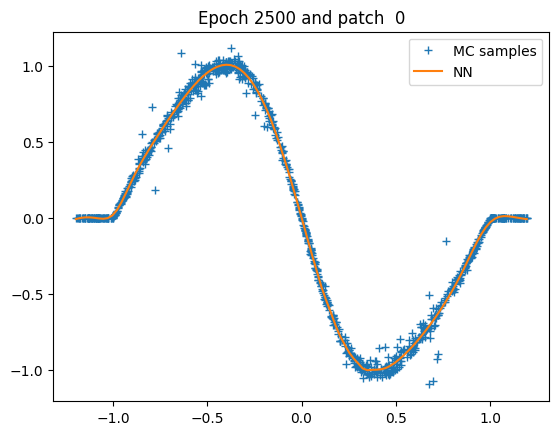

Patch  0: epoch 3000 with loss 1.79E-03


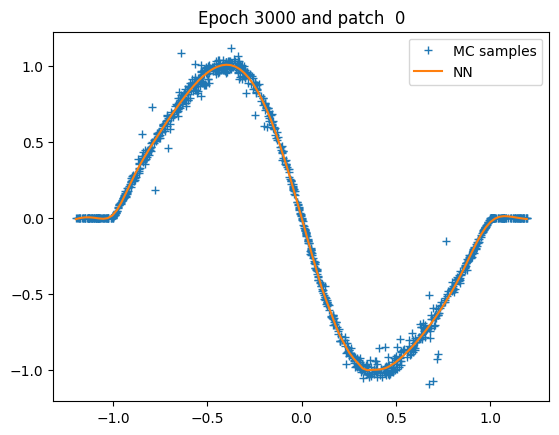

Patch  0: epoch 3500 with loss 1.79E-03


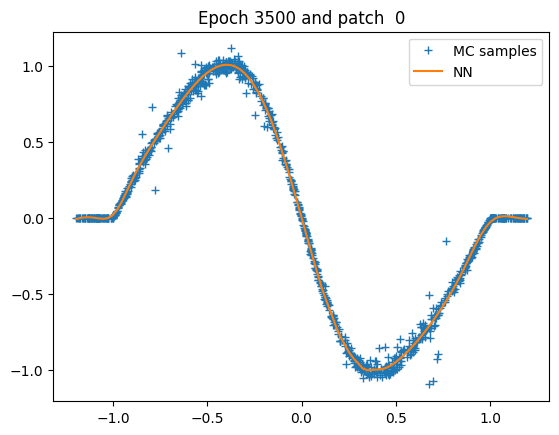

Patch  0: epoch 4000 with loss 1.79E-03


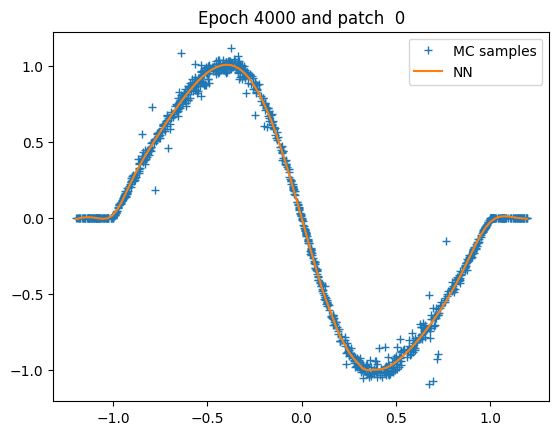

Patch  0: epoch 4500 with loss 1.79E-03


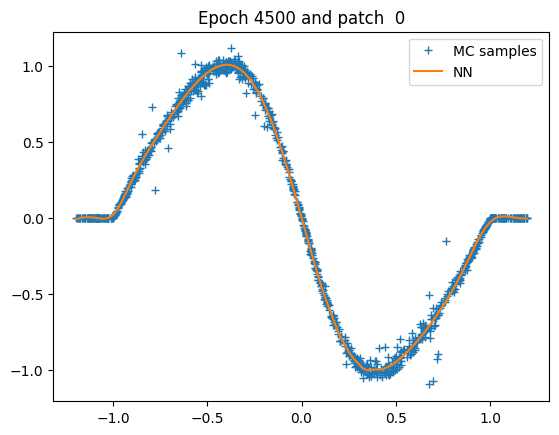

Patch  0: epoch 4999 with loss 1.78E-03


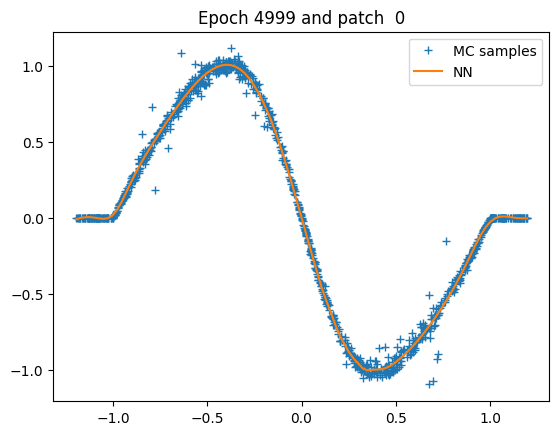

Patch 0: training of u with 5000 epochs take 38.22543811798096 seconds.
Logs are saved in C:\Users\User\OneDrive - Nanyang Technological University\School\Modules\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Time taken: 1644 seconds; L1 error: 1.10E-02; L2 error: 1.94E-04; rel error: 1.44E-01.
fdb runtime: 0 seconds; total runtime: 1644 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 1 times


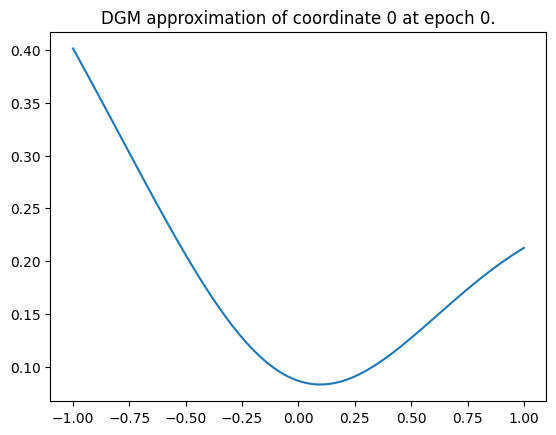

Epoch 0 with loss 1.0015268325805664


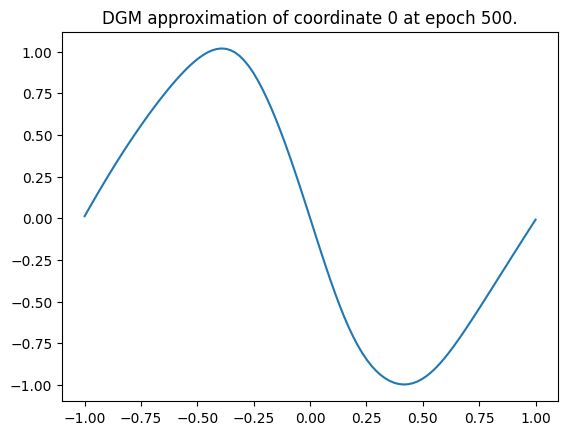

Epoch 500 with loss 0.0020260533783584833


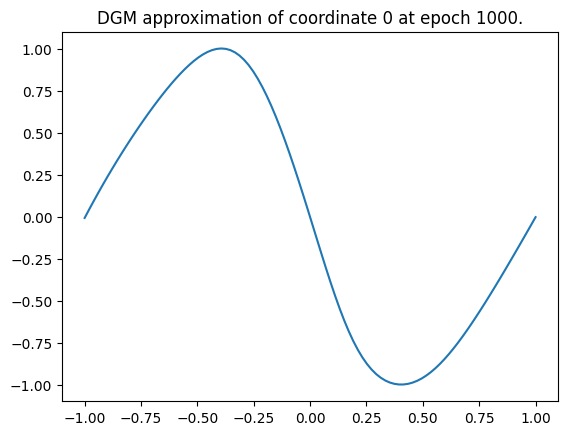

Epoch 1000 with loss 0.0007623358978889883


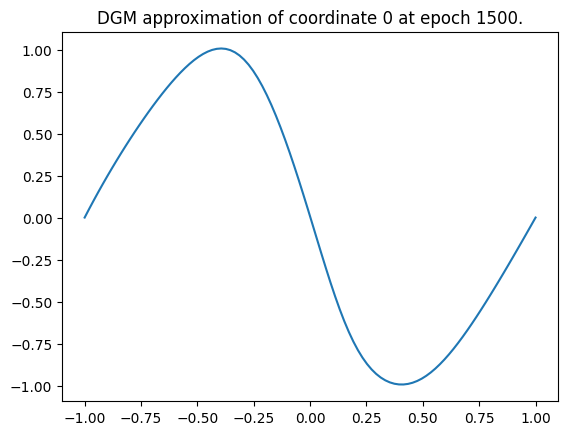

Epoch 1500 with loss 0.0004471781721804291


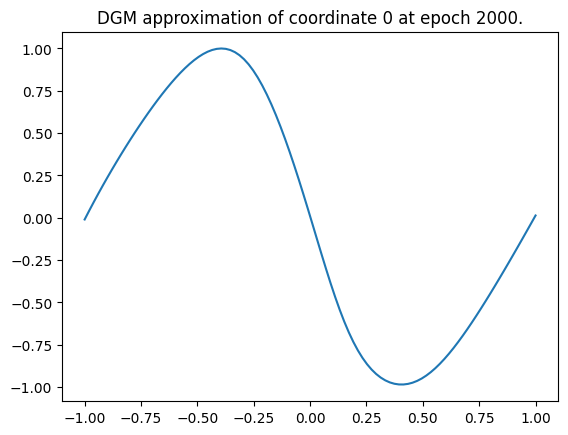

Epoch 2000 with loss 0.00045366946142166853


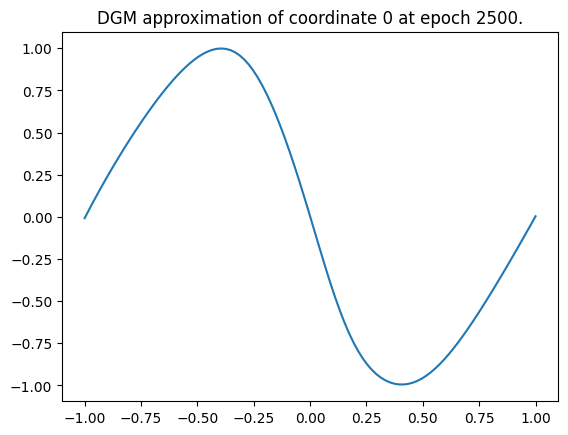

Epoch 2500 with loss 0.00020922395924571902


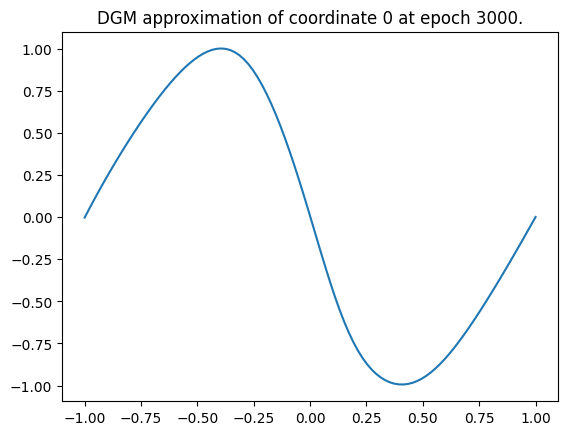

Epoch 3000 with loss 9.450111247133464e-05


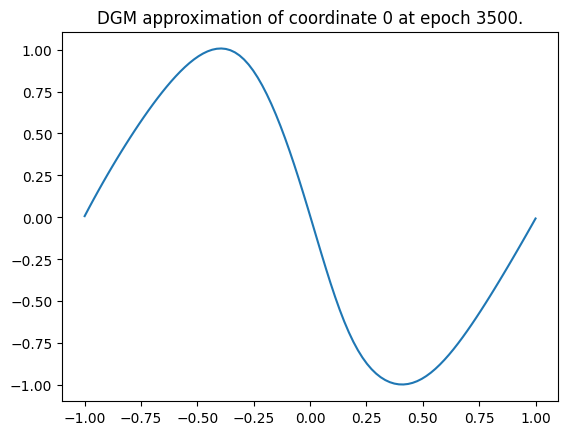

Epoch 3500 with loss 0.0002027401642408222


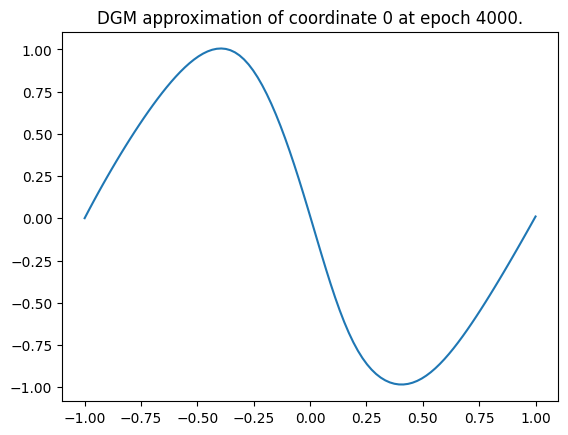

Epoch 4000 with loss 0.0004717896808870137


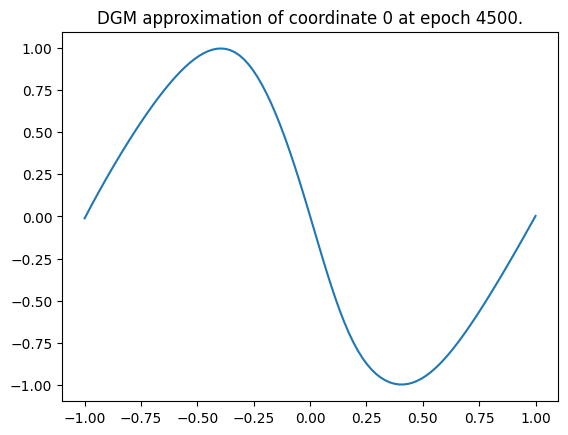

Epoch 4500 with loss 0.00032882444793358445


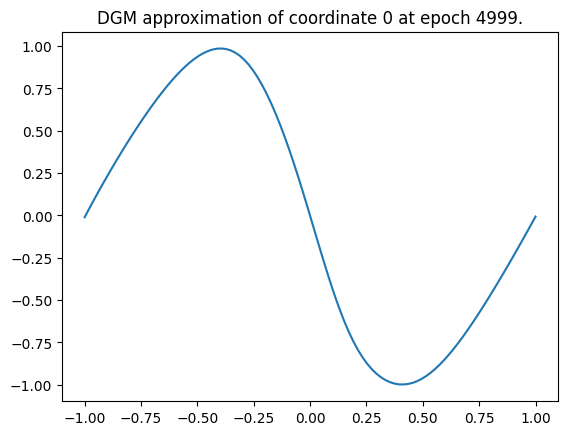

Epoch 4999 with loss 0.0016821394674479961
Training of neural network with 5000 epochs take 1813.794240951538 seconds.


Time taken: 1814 seconds; L1 error: 1.05E-02; L2 error: 1.73E-04; rel error: 7.48E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 1 times


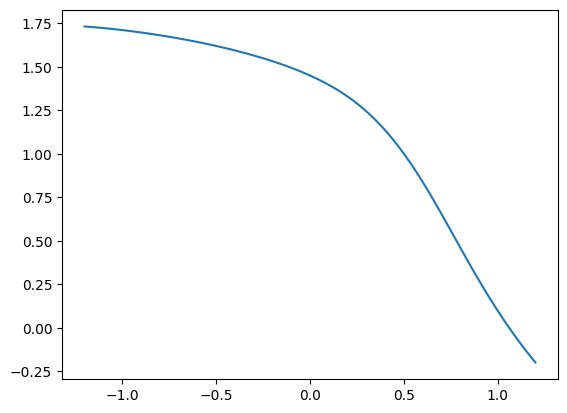

Epoch 0 with loss 0.6385583281517029


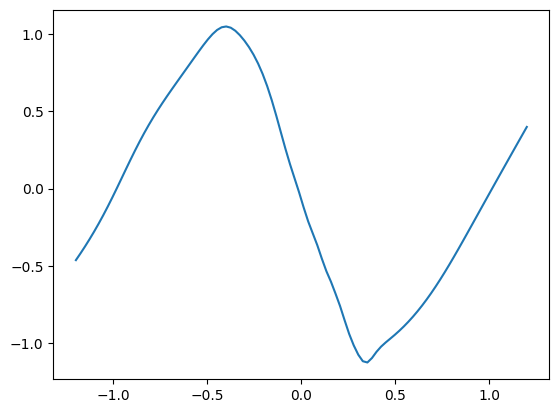

Epoch 500 with loss 0.0034505105577409267


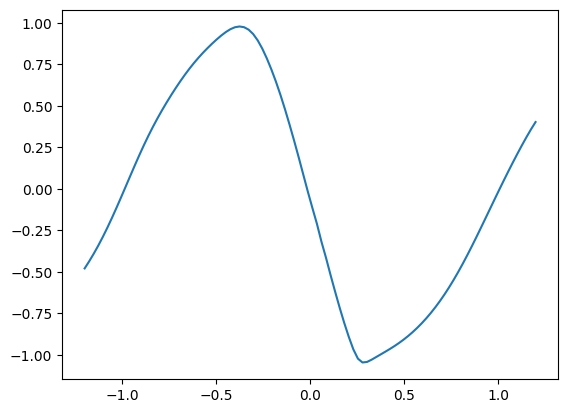

Epoch 1000 with loss 0.0033570139203220606


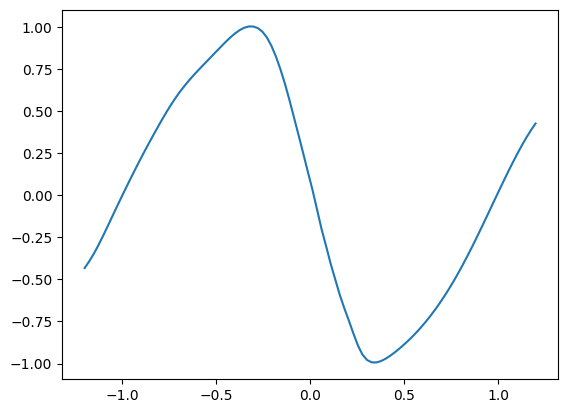

Epoch 1500 with loss 0.0011646646307781339


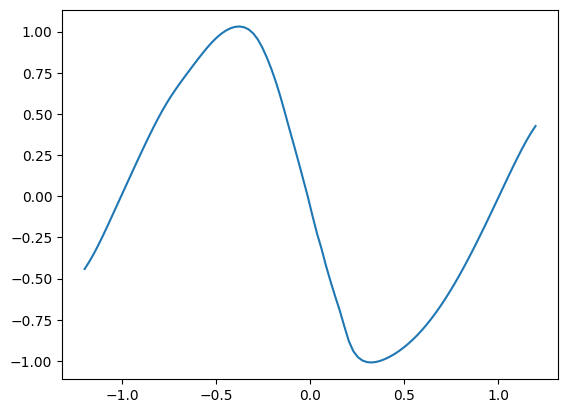

Epoch 2000 with loss 0.0016188073204830289


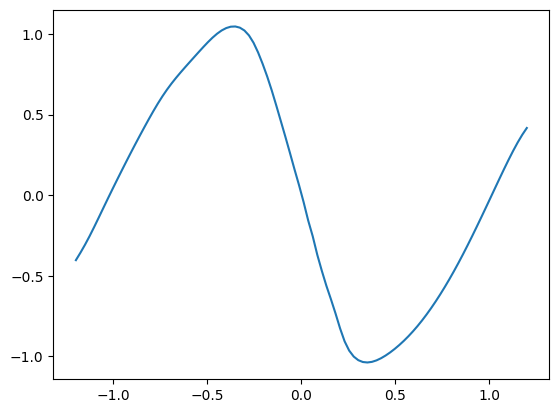

Epoch 2500 with loss 0.003233622759580612


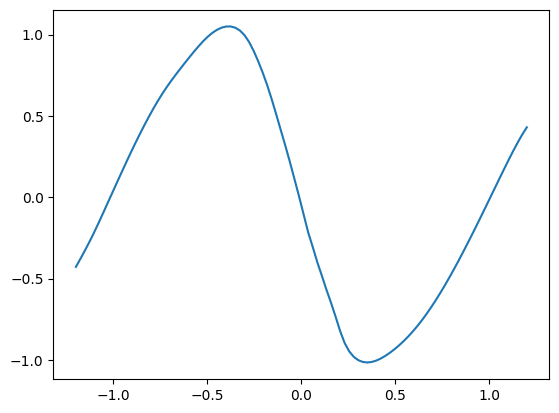

Epoch 3000 with loss 0.00420242128893733


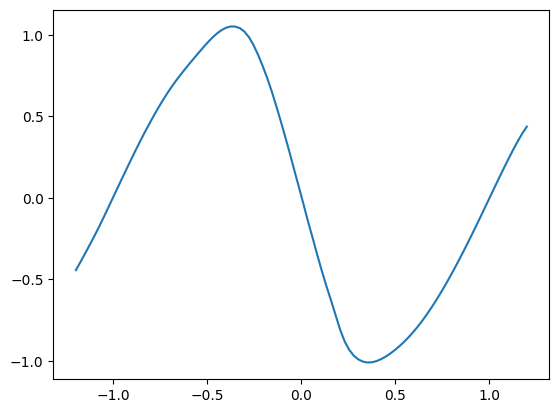

Epoch 3500 with loss 0.0031343272421509027


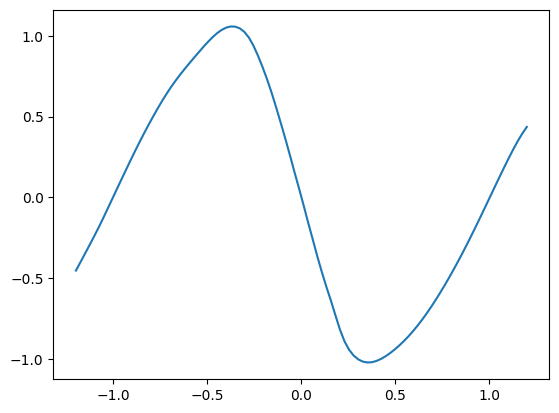

Epoch 4000 with loss 0.0003440295404288918


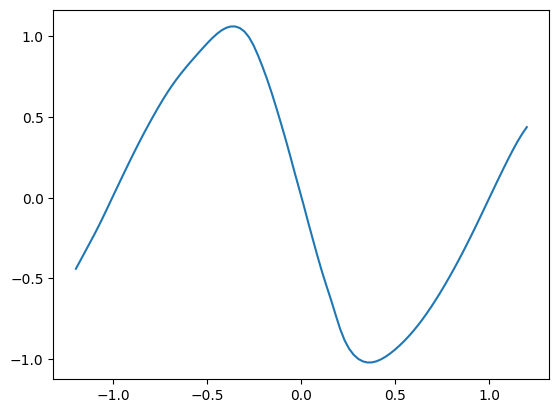

Epoch 4500 with loss 0.003093414707109332


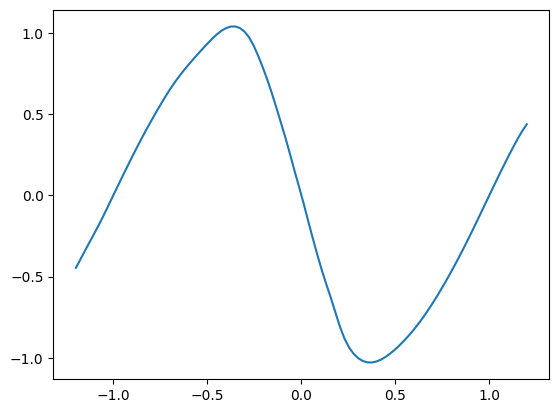

Epoch 4999 with loss 0.0008896134095266461
Training of neural network with 5000 epochs take 196.93976306915283 seconds.
Time taken: 197 seconds; L1 error: 2.07E-02; L2 error: 7.97E-04; rel error: 4.85E-02.




######## Summary for deep branching method
runtime:        1644
fdb runtime:    0
total runtime:  1644
mean L1 error:  1.10E-02
std L1 error:   0.00E+00
mean L2 error:  1.94E-04
std L2 error:   0.00E+00
mean rel error: 1.44E-01
std rel error:  0.00E+00


######## Summary for deep galerkin method
runtime:        1814
mean L1 error:  1.05E-02
std L1 error:   0.00E+00
mean L2 error:  1.73E-04
std L2 error:   0.00E+00
mean rel error: 7.48E-02
std rel error:  0.00E+00


######## Summary for deep BSDE method
runtime:        197
mean L1 error:  2.07E-02
std L1 error:   0.00E+00
mean L2 error:  7.97E-04
std L2 error:   0.00E+00
mean rel error: 4.85E-02
std rel error:  0.00E+00


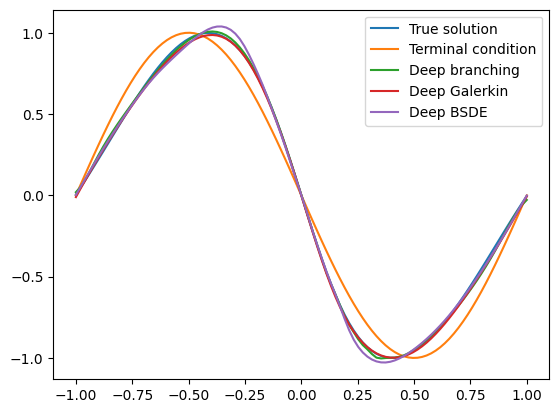

In [14]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_low, true, terminal=terminal, seeds=[0],
                    # disable_branch=True,
                    # disable_bsde=True, 
                    # disable_galerkin=True, 
                    debug_mode=True, 
                    verbose=True, 
                    conditional_probability_to_survive=partial(conditional_probability_to_survive),
                    is_x_inside=partial(is_x_inside), 
                    y_lo=x_low, y_hi=x_high, 
                    nu=0.02/np.pi,
                    T=T, device=device, epochs=5000, fname="burgers",
                    branch_nb_states=1000, branch_nb_path_per_state=10000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example,
                    boundary_fun=boundary_fun, dgm_overtrain_rate=0,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=8,
                    save_for_best_model=False, save_as_tmp=True)